In [ ]:
import torch
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import google.generativeai as genai
from typing import List, Dict, Any
import re
from utlis.prompt import *

# Run the model on the test dataset to get result.

In [ ]:

def parse_ai_detection_result(generated_text: str):
    # Remove markdown-style code fences if present
    cleaned = re.sub(r"^```json|^```|```$", "", generated_text.strip(), flags=re.MULTILINE).strip()

    # Try to load as JSON
    try:
        pred_json = json.loads(cleaned)
    except json.JSONDecodeError:
        # Fallback: extract first JSON object found in text
        match = re.search(r'\{.*\}', cleaned, re.DOTALL)
        if not match:
            raise ValueError("No valid JSON object found in response")
        pred_json = json.loads(match.group())

    prediction = pred_json['label']
    reasoning = pred_json['reasoning']
    return prediction, reasoning

In [ ]:
is_rubric = True
is_example = True
domains = ['engineering', 'it','psychology', 'teaching', 'accounting'] #'
path = 'Training_Data/'

ai_detection_save = 'output_data/Detection_AI'
gen_save = 'output_data/Feedback_Gen'
os.makedirs(ai_detection_save, exist_ok=True)
os.makedirs(gen_save, exist_ok=True)

#Go through different domain and its json file
for domain in domains:
    #Load the training file
    file = path + domain + '.json' 
    with open(file, 'r') as file:
        data = json.load(file) #Get the data file

    #Get the rubric of the domain
    rubric = format_rubric(data['rubric'])
    example = create_few_shot_block(data['submissions'])

    ai_results = []
    gen_results = []

    for s in tqdm(data["submissions"]):
        text = s.get("final_submission", "")
        label = s.get("label_type", "")
        #build prompt for this submission
        detector_prompt = build_detection_prompt(submission = text, example = example) #AI dection prompt
        feedback_prompt = build_feedback_prompt(submission = text, rubric = rubric) #Feedback generation AI


        # Run AI Detector and Feedback AI
        ai_pred, _ = parse_ai_detection_result(generated_response_gemini(message= detector_prompt))
        feedback_result = generated_response_gemini(message= feedback_prompt)

        #Save the result
        ai_results.append({ "text": text, "labels": label, "predictions": ai_pred})
        gen_results.append({"text": text, "generated_text": feedback_result, "rubric": rubric})

    print("Saving to file")
    #Save the result to CSV file
    detection_df = pd.DataFrame(ai_results)
    gen_df = pd.DataFrame(gen_results)
    detection_df.to_csv(f"run/Detection_AI/{domain}.csv")
    gen_df.to_csv(f'run/Feedback_Gen/{domain}.csv')
    display(detection_df)
    display(gen_df)

# Evaluate the performance of the model

***************** engineering *****************


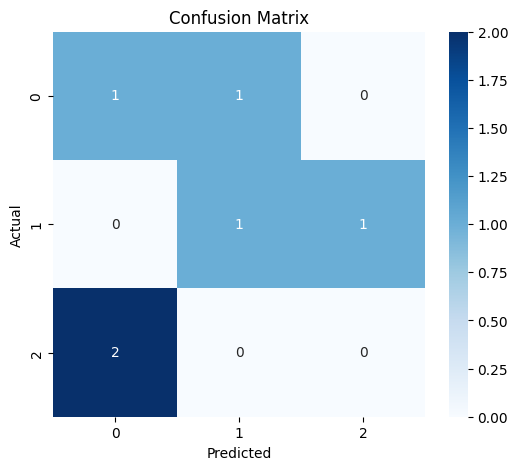

Accuracy: 0.3333
F1-score: 0.3000
Recall: 0.3333
Precision: 0.2778

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.28      0.33      0.30         6
weighted avg       0.28      0.33      0.30         6

Results saved to save/Detection_AI/teaching_results.txt
***************** it *****************


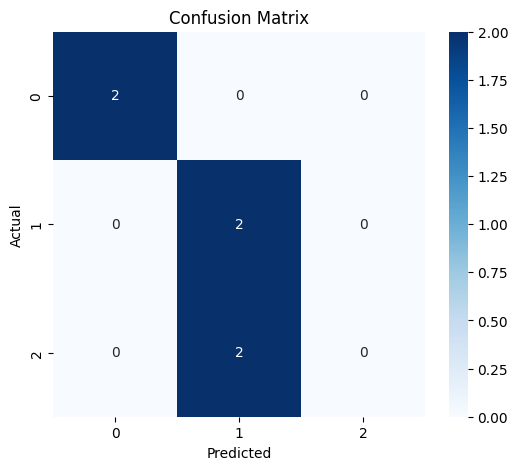

Accuracy: 0.6667
F1-score: 0.5556
Recall: 0.6667
Precision: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.50      1.00      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6

Results saved to save/Detection_AI/teaching_results.txt
***************** psychology *****************


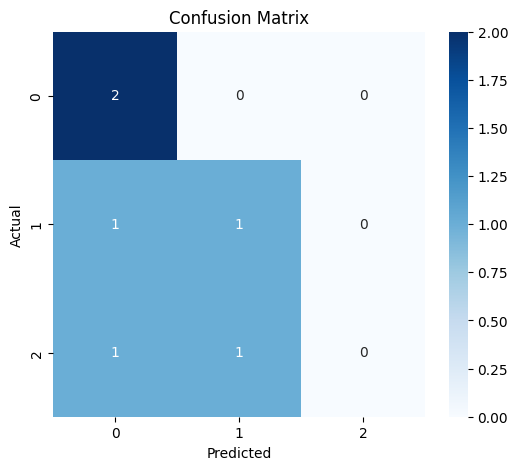

Accuracy: 0.5000
F1-score: 0.3889
Recall: 0.5000
Precision: 0.3333

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.33      0.50      0.39         6
weighted avg       0.33      0.50      0.39         6

Results saved to save/Detection_AI/teaching_results.txt
***************** teaching *****************


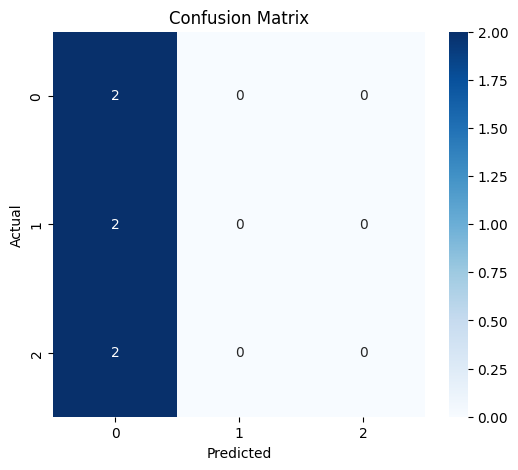

Accuracy: 0.3333
F1-score: 0.1667
Recall: 0.3333
Precision: 0.1111

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

Results saved to save/Detection_AI/teaching_results.txt
***************** accounting *****************


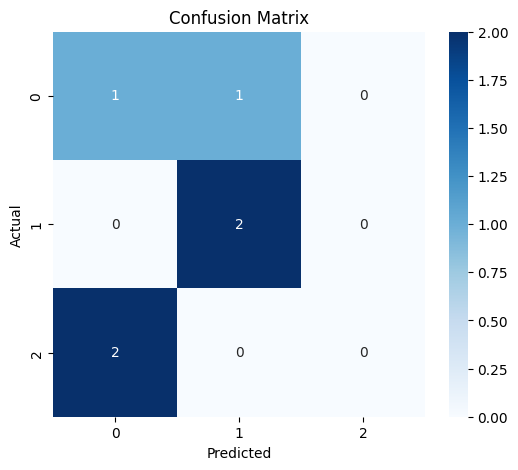

Accuracy: 0.5000
F1-score: 0.4000
Recall: 0.5000
Precision: 0.3333

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.33      0.50      0.40         6

Results saved to save/Detection_AI/teaching_results.txt


In [ ]:
from evaluate_model_genai import EvaluateModel

domains = ['engineering', 'it','psychology', 'teaching', 'accounting'] 
ai_path = 'run/Detection_AI'
store_path = 'save/Detection_AI'
os.makedirs(store_path, exist_ok=True)

for domain in domains:
    print(f"***************** {domain} *****************")
    dataset_path = ai_path + '/' + domain + '.csv'
    testset = pd.read_csv(dataset_path)
    
    evaluateModel = EvaluateModel(
        dataset=testset,
        model_type="ai_detection",
        device="automap"   # feedback_generation/ai_detection
    )
    
    evaluateModel.evaluate_classification_model(print_result=True)
    evaluateModel.construct_data_message()  # Create the prompt for the dataset

    # open plain text file for saving results
    output_file = f"results_{domain}.txt"
    with open(output_file, "w", encoding="utf-8") as f:
        for prompt in evaluateModel.dataset_prompt:
            result = generated_response_gemini(prompt)
            try:
                pred_json = json.loads(result)
                line = f"Overall: {pred_json.get('Overall', 'N/A')}\n"
            except Exception:
                # if not valid JSON, just dump raw result
                line = result.strip() + "\n"

            print(line.strip())
            f.write(line)

    print(f"Results saved to {output_file}")



In [ ]:
import pandas as pd
import json

from evaluate_model_genai import EvaluateModel

domains = ['psychology', 'teaching']
ai_path = 'run/Feedback_Gen'

for domain in domains:
    print(f"***************** {domain} *****************")
    dataset_path = ai_path + '/' + domain + '.csv'
    testset = pd.read_csv(dataset_path)

    evaluateModel = EvaluateModel(
        dataset=testset, 
        model_type="feedback_generation",  # or "ai_detection"
        device="automap"
    )
    evaluateModel.construct_data_message()  # Create the prompt for the dataset

    # open plain text file for saving results
    output_file = f"results_{domain}.txt"
    with open(output_file, "w", encoding="utf-8") as f:
        for prompt in evaluateModel.dataset_prompt:
            result = generated_response_gemini(prompt)
            try:
                pred_json = json.loads(result)
                line = f"Overall: {pred_json.get('Overall', 'N/A')}\n"
            except Exception:
                # if not valid JSON, just dump raw result
                line = result.strip() + "\n"

            print(line.strip())
            f.write(line)
